<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/toy_examples/n_centered_moment_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import numpy as np
import math
import itertools

from scipy import signal

import matplotlib.pyplot as plt

# Toy example one hot vector (one-sided)

In this example we want to prove the importance method with a one-hot datset so that we are not dealing with an ill-posed solution, like with the numbered class labels.

In [2]:
def MNIST_data(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], one_hot_labels=False):
    # distribution: distribution for each label
    # returns (data, labels) for MNIST with all the classes; zeroes and ones have the given distribution

    MNIST = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    distribution /= np.array(distribution).sum()
    
    # bool mask for each label
    idxm = [MNIST.targets==label for label in range(len(distribution))]
    min_idx = torch.Tensor([sum(i) for i in idxm]).min().int().item()
    tot_idx = torch.Tensor([sum(i) for i in idxm]).sum().int().item()

    # list of indices for each label
    idx = [np.where(idxm[label])[0] for label in range(len(distribution))]
    
    len_idx = torch.Tensor([len(i) for i in idx])
    wanted_len = torch.Tensor([d*tot_idx for d in distribution])
    
    min_class = ((len_idx/wanted_len).argmin())
    min = ((len_idx/wanted_len).min().item())

    if min < 1:
      distribution *= min

    valid_idx = []
    class_len = [math.floor(d*tot_idx) for d in distribution]
    for label, length in enumerate(class_len):
      valid_idx += idx[label][:length].tolist()

    valid_idx = np.array(valid_idx)
    np.random.shuffle(valid_idx)

    # assign the new data and labels to the dataset
    if one_hot_labels:
      MNIST.targets = torch.nn.functional.one_hot(MNIST.targets[valid_idx])
    else:
      MNIST.targets = MNIST.targets[valid_idx]
    MNIST.data = MNIST.data[valid_idx]

    return MNIST 

In [3]:
MNIST_data([0.5, 0.5])

Dataset MNIST
    Number of datapoints: 11846
    Root location: /files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
class MNISTDataset(Dataset):
    '''The dataset for the MNIST binary data
    '''
    def __init__(self, distribution = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], one_hot_labels = False):

        self.ratio = distribution        
        self.dataset = MNIST_data(distribution=self.ratio, one_hot_labels=one_hot_labels)
        self.example_imgs = self.example()
        
        # to take out in real applications
        self.unique_labels = torch.unique(self.dataset.targets)[:len(distribution)]

    def example(self):
        '''
        Returns an example from each digit in the domain
        
        '''
        labels = self.dataset.targets
        data = self.dataset.data
        '''img0 = data[labels==0][0].unsqueeze(0)
        img1 = data[labels==1][0].unsqueeze(0)
        img2 = data[labels==2][0].unsqueeze(0)
        img3 = data[labels==3][0].unsqueeze(0)
        img4 = data[labels==4][0].unsqueeze(0)
        img5 = data[labels==5][0].unsqueeze(0)
        img6 = data[labels==6][0].unsqueeze(0)
        img7 = data[labels==7][0].unsqueeze(0)
        img8 = data[labels==8][0].unsqueeze(0)
        img9 = data[labels==9][0].unsqueeze(0)
        ex = torch.cat((img0, img1, img2, img3, img4, img5, img6, img7, img8, img9), 0)'''
        img = []
        for label in torch.unique(labels)[:len(self.ratio)]:
          img = img + [data[labels==label][0].unsqueeze(0)]
        ex = torch.cat(img, 0)
              
        return ex

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

In this example we have 2 domains with 10 classes. Only the first two classes have a different probability.

In [10]:
batch_size = 256

# Settings for domain A
dataset_A = MNISTDataset(distribution=[0.05, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# dataset_A = MNISTDataset(distribution=[0.2, 0.8])
dataloader_A = DataLoader(dataset_A, batch_size, shuffle=True)

# Settings for domain B
dataset_B = MNISTDataset(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# dataset_B = MNISTDataset(distribution=[0.5, 0.5])
dataloader_B = DataLoader(dataset_B, batch_size, shuffle=True)

In [11]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x), x

In [12]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [13]:
def raw_to_onehot(labels): # TODO: rekening houden met missend label in kleine batch
  onehot = torch.zeros(len(labels), len(labels.unique()))
  for c in labels.unique():
    onehot[labels==c, c] = 1
  return onehot

In [14]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

# For storing results
losses_w = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 2 # n-centered moment

for epoch in range(5):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        
        img_A = real_A[0].cuda()
        img_B = real_B[0].cuda()

        label_A = raw_to_onehot(real_A[1]).cuda()
        label_B = raw_to_onehot(real_B[1]).cuda()

        # The weighting process
        w_A = weight_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A = n_centered_moment(label_A, w_A, n)
        n_centered_moment_B = n_centered_moment(label_B, w_B, n)
        loss_w = ((n_centered_moment_A - n_centered_moment_B)**2).sum()

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(label_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(label_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(label_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(label_B, w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]
        
        w_a = weight_network(dataset_A.example_imgs.cuda().unsqueeze(1).float())
        example_importances_A += [[importance.item() for importance in w_a[0]]] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 50 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

step 0 loss_w:  0.012276814319193363
step 50 loss_w:  0.007600788027048111
step 100 loss_w:  0.003543618367984891
step 150 loss_w:  0.009538608603179455
step 0 loss_w:  0.0019436073489487171
step 50 loss_w:  0.0037005769554525614
step 100 loss_w:  0.006849383935332298
step 150 loss_w:  0.007915355265140533
step 0 loss_w:  0.004232139326632023
step 50 loss_w:  0.006825888995081186
step 100 loss_w:  0.0037424536421895027
step 150 loss_w:  0.006409966386854649
step 0 loss_w:  0.0030837086960673332
step 50 loss_w:  0.004206347744911909
step 100 loss_w:  0.00380839710123837
step 150 loss_w:  0.0008835929329507053
step 0 loss_w:  0.0051784939132630825
step 50 loss_w:  0.00593949481844902
step 100 loss_w:  0.00736307492479682
step 150 loss_w:  0.0031021188478916883


## Results
In the plot below we see that the loss of W is going down.

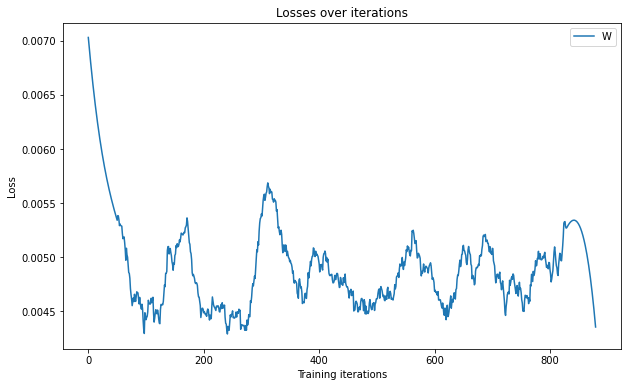

In [15]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

The plot below shows that the classes 0 and 1 in domain A are weighted to match the uniform distribution in domain B.

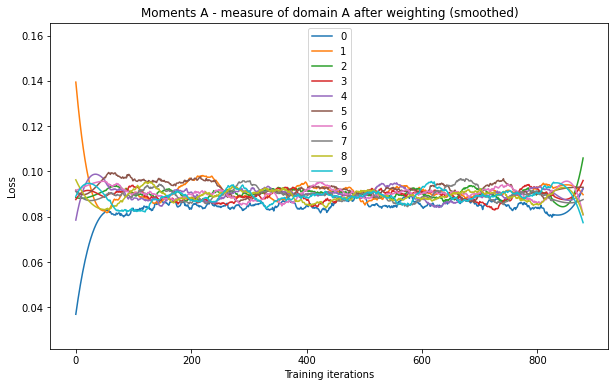

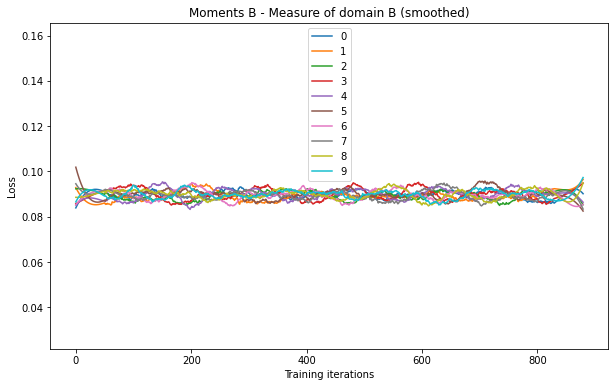

In [16]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

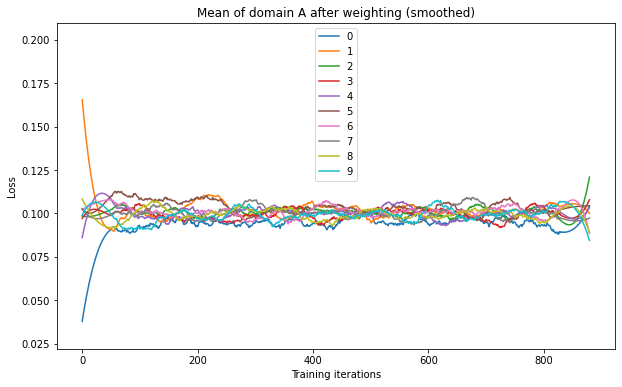

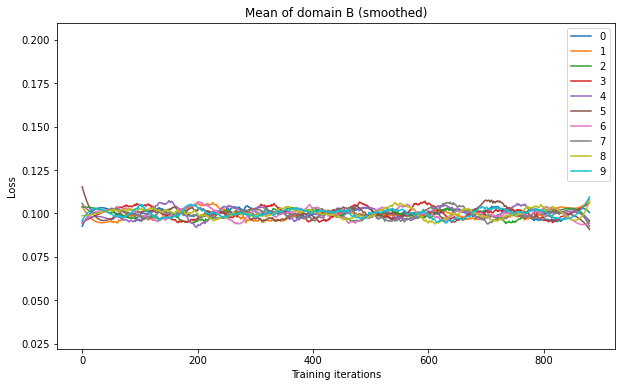

In [17]:
plt.figure(figsize=(10,6))
plt.title('Mean of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = means_A.max(), ymin = means_A.min())
smoothed_means_A = signal.savgol_filter(means_A,101,3,axis=0)
plt.plot(smoothed_means_A)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Mean of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = means_A.max(), ymin = means_A.min())
smoothed_means_B = signal.savgol_filter(means_B,101,3,axis=0)
plt.plot(smoothed_means_B)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

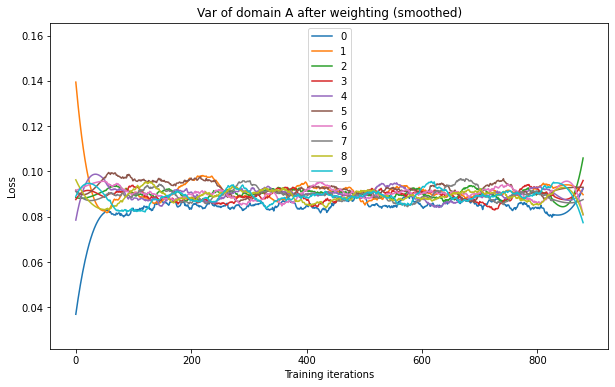

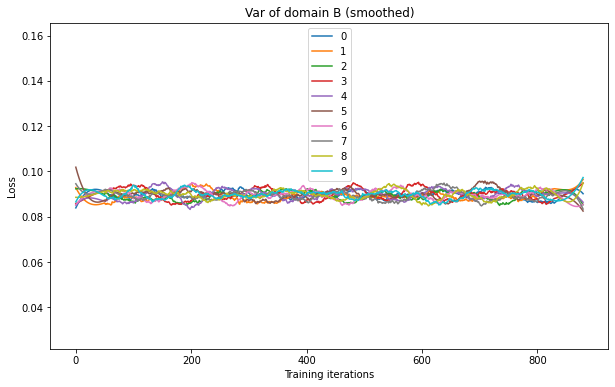

In [18]:
plt.figure(figsize=(10,6))
plt.title('Var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = vars_A.max(), ymin = vars_A.min())
smoothed_vars_A = signal.savgol_filter(vars_A,101,3,axis=0)
plt.plot(smoothed_vars_A)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Var of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = vars_A.max(), ymin = vars_A.min())
smoothed_vars_B = signal.savgol_filter(vars_B,101,3,axis=0)
plt.plot(smoothed_vars_B)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

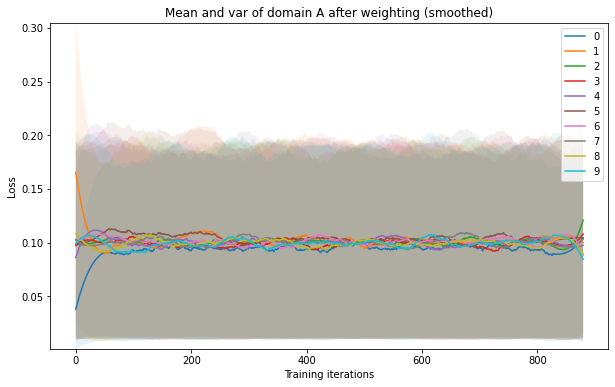

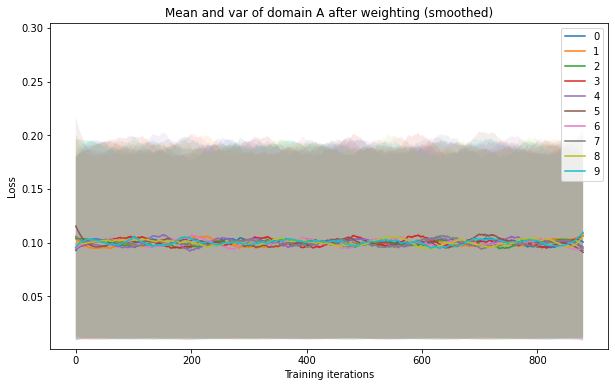

In [19]:
plt.figure(figsize=(10,6))
plt.title('Mean and var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = (smoothed_means_A + smoothed_vars_A).max(), ymin = (smoothed_means_A - smoothed_vars_A).min())
plt.plot(smoothed_means_A)
for i in range(smoothed_means_A.shape[1]):
  plt.fill_between(np.arange(len(smoothed_means_A)), (smoothed_means_A - smoothed_vars_A)[:, i], (smoothed_means_A + smoothed_vars_A)[:, i], alpha=0.1)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Mean and var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = (smoothed_means_A + smoothed_vars_A).max(), ymin = (smoothed_means_A - smoothed_vars_A).min())
plt.plot(smoothed_means_B)
for i in range(smoothed_means_B.shape[1]):
  plt.fill_between(np.arange(len(smoothed_means_B)), (smoothed_means_B - smoothed_vars_B)[:, i], (smoothed_means_B + smoothed_vars_B)[:, i], alpha=0.1)
plt.legend(np.arange(len(moments_A[0])))
plt.show()

Here you see the weights assigned to the classes in domain A. As expected, 0 gets a large weight as it is underrepresented in domain A, and 1 gets a small weight as it is overrepresented in domain A.

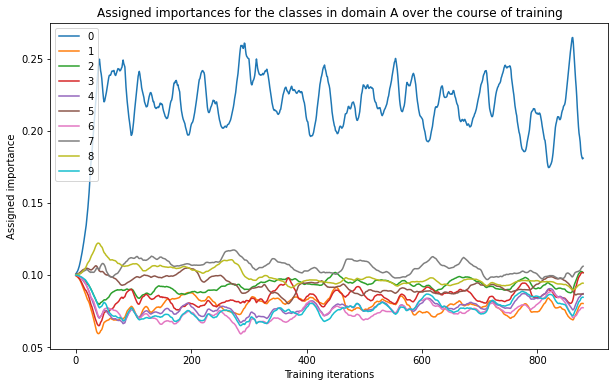

In [20]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the classes in domain A over the course of training')
plt.plot(example_importances_A)
plt.legend(np.arange(10))
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()